# Imports, Fixed training pms, util fions


In [1]:
# imports
import os
import pickle
from copy import deepcopy
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.auto import tqdm
from time import time, sleep
from torch.utils.data import DataLoader, SubsetRandomSampler, SequentialSampler
import torch.optim as optim
from sklearn.model_selection import KFold, StratifiedKFold

try:
  print("Path to Thesis =", ptt)
except:
  if "drive" in os.listdir():
    print("Working on GDrive.")
    ptt = ""
    %cd /content/drive/My\ Drive/Thesis/
  else:
    print("Working on local device.")
    ptt = os.path.expanduser("~/thesis")
    print("pathToThesis =", ptt)

from NNClasses import *
from NNDataLoader import *
from NN_train_util import *
from util import plotXYGrid_colorbar, plot_torch_distr

%load_ext autoreload
%autoreload 1
%aimport NNDataLoader
%aimport NN_train_util
%aimport util

# ----------------------------
# FIXED TRAINING PARAMETERS
# ----------------------------

early_stop_patience = 50
Tc0 = .894 #from "Critical behavior of the two-dimensional XYmodel", Gupta & Baillie, 1992
early_stopping_enabled = True # True  
criterion = nn.BCELoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"torch device: {device}")

Working on GDrive.
/content/drive/My Drive/Thesis
torch device: cpu


In [2]:
# Helper functions
print("We have assumed that the variable ptt exists and is the path to Thesis folder.")

def get_scores(training_id, modelName, L, fold_id=1, old=False):
  """Returns pandas DataFrame of scores as saved in simple training loop."""
  if not old:
    path = os.path.join(ptt, "data", "test_results", f"NN_{training_id}_{modelName}_L={L}", f"scores_fold={fold_id}.csv")
  else:
    path = os.path.join(ptt, "data", "test_results", f"NN_{training_id}_{modelName}_L={L}", f"scores_fold={fold_id}.csv")
  return pd.read_csv(path, sep=";", header=[0,1], index_col=[0])


def get_models_test_results(training_id, modelName, num_folds, L):
  """Returns models found in folder given by
  training_id, modelName, num_folds and L."""
  models = []
  path = os.path.join(ptt, "data", "test_results", f"NN_{training_id}_{modelName}_L={L}")
  print("Finding models at:", path)
  if os.path.isdir(path):
    getModelPath = lambda i : os.path.join(path, f"torch_model_fold={i}_of_{num_folds}.dat")

    model_i = 1
    model_path = getModelPath(model_i)
    while os.path.isfile(model_path):
      models.append(torch.load(model_path, map_location=device))

      model_i += 1
      model_path = getModelPath(model_i)
    assert model_i > 1, f"At least 1 model is expected, nothing found at {model_path}"
    print(f"Succesfully loaded in {len(models)} models.")
    return models
  else:
    raise FileNotFoundError("No such folder exists: ", path)



def load_model_test_report_lossAcc(train_id, namePrefix, modelName, L, folds, data_state_vortices, bs=10000):
  """Loads models (all folds) def by train_id, name_prefix, modelName and L.
  Loads test set of right size."""
  # ----------------
  # GET ALL DATA
  # ----------------
  modelName = namePrefix + "_" + modelName
  models = get_models_test_results(train_id, modelName, folds, L)
  
  # test dataSets are already normalized
  test_data = load_data_from_pickle(L, trainSet=False, normalize=True,
                                    train_on_vortex=data_state_vortices, device=device, pathToThesis=ptt)
  print(
      f"Succesfully loaded dataset (L={L}) containing {len(test_data)} samples.")

  # ----------------
  # TESTING
  # ----------------
  test_sampler = SequentialSampler(test_data)
  test_loader = DataLoader(
      test_data, batch_size=bs, sampler=test_sampler)
  results = np.zeros((len(models), 2))

  num_batches = len(test_loader)
  
  for model_id, model in enumerate(models):
    model_loss, model_acc = 0, 0

    model.eval()  # eval mode, not model.train() for train mode
    with torch.no_grad():  # no grad calculations
      for data, label in test_loader:
        output = model(data)
        batch_loss = criterion(output, label)

        # threshold value of 0.5 to determine class.
        batch_acc = ((output > 0.5).float() == label).float().mean().item()
        model_acc += batch_acc / num_batches
        model_loss += batch_loss.item() / num_batches

    results[model_id] = model_loss, model_acc
  
  print(f"Succesfully tested {model.name} model with an average acc of ",
        f"{results[:,1].mean()*100:0.2f}%")
  return results



def load_test_report_lossAcc_for_model(test_data, model, bs=10000):
  """Loads models (all folds) def by train_id, name_prefix, modelName and L.
  Loads test set of right size."""
  
  test_sampler = SequentialSampler(test_data)
  test_loader = DataLoader(
      test_data, batch_size=bs, sampler=test_sampler)
  results = np.zeros(1, 2)

  num_batches = len(test_loader)
  model_loss, model_acc = 0, 0

  model.eval()  # eval mode, not model.train() for train mode
  with torch.no_grad():  # no grad calculations
    for data, label in test_loader:
      output = model(data)
      batch_loss = criterion(output, label)

      # threshold value of 0.5 to determine class.
      batch_acc = ((output > 0.5).float() == label).float().mean().item()
      model_acc += batch_acc / num_batches
      model_loss += batch_loss.item() / num_batches

  results[model_id] = model_loss, model_acc
  print(f"Succesfully tested {model.name} model with an average acc of ",
        f"{results[:,1].mean()*100:0.2f}%")
  return results

def gen_fake_data(N_samples, L :int, T_low : bool, degrees_seperation=5, silence=True):
  """Generates dataset, values between -pi and +pi.
  Used to train model with, to check if model can learn to predict either one model"""
  if T_low:
    set = np.random.rand(N_samples)*2*np.pi - np.pi
    set = np.repeat(set, L*L)
    set = np.reshape(set, (N, L, L))

    seperation = (degrees_seperation/2 * np.pi) / 180
    seperation = (np.random.rand(N, L, L)-0.5) * 2 * seperation

    set += seperation
  else:
    set = np.random.rand(N_samples, L, L) * 2*np.pi - np.pi

  set /= 2 * np.pi  # normalize
  set = sawtooth_normalized(torch.from_numpy(set)).cpu().numpy()

  if not silence:
    plotXYGrid_colorbar(set[0,:,:]*2*np.pi)
  return set

We have assumed that the variable ptt exists and is the path to Thesis folder.


# One set of models

## Load models and data

### Models

Check in GDrive which `training_id`, `modelName` and `L` is wanted.

In [86]:
# ----------------
# PARAMETERS
# ----------------
plot_folds_early = False

training_id = 1
modelName_pre = "New"

#for modelName in ["FFNN", "CNN", "CNN_vortices", "CustomNN_vortexInit", "CustomNN_randomInit"]:

modelName = "CNN_vortices"
modelName_og = deepcopy(modelName)
folds = 10
L = 16
normalized_data = True

if True: # automatically fix trainin_id and prefix
  id_prefix_Lsixteen_dict = {
    "FFNN": (0, "CRAZY"),
    "CNN": ("0599", "TEMP"),
    "CNN_vortices":(536, "Newer2"),
    "CustomNN_vortexInit":(16397, "REZERO"),
    "CustomNN_randomInit":(55, "LongerRun")}
  if L == 16:
    print("Modelname Parameters Overwritten, because L==16")
    training_id, modelName_pre = id_prefix_Lsixteen_dict[modelName]

# ----------------
# GET ALL DATA
# ----------------
train_on_vortex = modelName[-8:] == "vortices"
modelName = modelName_pre + "_" + modelName
models = get_models_test_results(training_id, modelName, folds, L)

# test dataSets are already normalized
test_data = load_data_from_pickle(L, trainSet=False, normalize=normalized_data, train_on_vortex=train_on_vortex, device=device, pathToThesis=ptt) 
print(f"Succesfully loaded dataset containing {len(test_data)} samples.")

# temp location
if plot_folds_early:
  for i in range(folds):
    try:
      scores = get_scores(training_id, modelName, L, fold_id=i)

      fig, ax = plt.subplots(figsize=(4,3), dpi=250)
      ax.set_ylim(0,1)
      ax.set_ylabel("Loss/Accuracy")
      scores.plot(ax=ax)

      if modelName_og == "CNN_vortices":
        # plot horizontal lines
        ax.axhline(y=0.719, lw=0.5, ls=":", alpha=.5, color="gray")
        ax.axhline(y=0.281, lw=0.5, ls=":", alpha=.5, color="gray")

      fig.savefig(os.path.join("data", "learning_curves", f"{modelName_og}_lc_fold={i}.png"),
                  bbox_inches='tight')
      ax.get_legend().remove()        
      fig.savefig(os.path.join("data", "learning_curves", f"{modelName_og}_lc_fold={i}_NOLEGEND.png"),
                  bbox_inches='tight')
      plt.close("all")
      
    except:
      break    

Modelname Parameters Overwritten, because L==16
Finding models at: data/test_results/NN_536_Newer2_CNN_vortices_L=16
Succesfully loaded in 5 models.
vortex from spin device: cpu
Succesfully loaded dataset containing 6400 samples.


## Test performance on test data

With loaded in test data, we can calculate average and variance of accuracy and loss accross the different folds (for which we have a model stored in `models`).

For every model:
1. Loop over batches of test data
2. Calculate `loss` and `acc`

In [87]:
batch_size=100

num_samples = len(test_data)
test_sampler = SequentialSampler(test_data)
test_loader = DataLoader(test_data, batch_size=batch_size, sampler=test_sampler)
results = np.zeros((len(models), 2))

num_batches = len(test_loader)
Ts_and_acc = torch.empty(len(models), num_batches, 3, batch_size)
for model_id, model in enumerate(models):
  model_loss, model_acc = 0,0
  i = 0
  model.eval() # eval mode, not model.train() for train mode
  with torch.no_grad(): # no grad calculations
    for data, label, T in test_loader:
      num_samples_batch = len(data)
      
      output = model(data)      
      batch_loss = criterion(output, label)
      
      # threshold value of 0.5 to determine class.
      batch_acc = ((output > 0.5).float() == label).float().mean().item()
      model_acc += batch_acc / num_batches
      model_loss += batch_loss.item() / num_batches

      Ts_and_acc[model_id, i, 0] = T
      Ts_and_acc[model_id, i, 1] = batch_acc
      Ts_and_acc[model_id, i, 2] = batch_loss
      i += 1
      
  results[model_id] = model_loss, model_acc

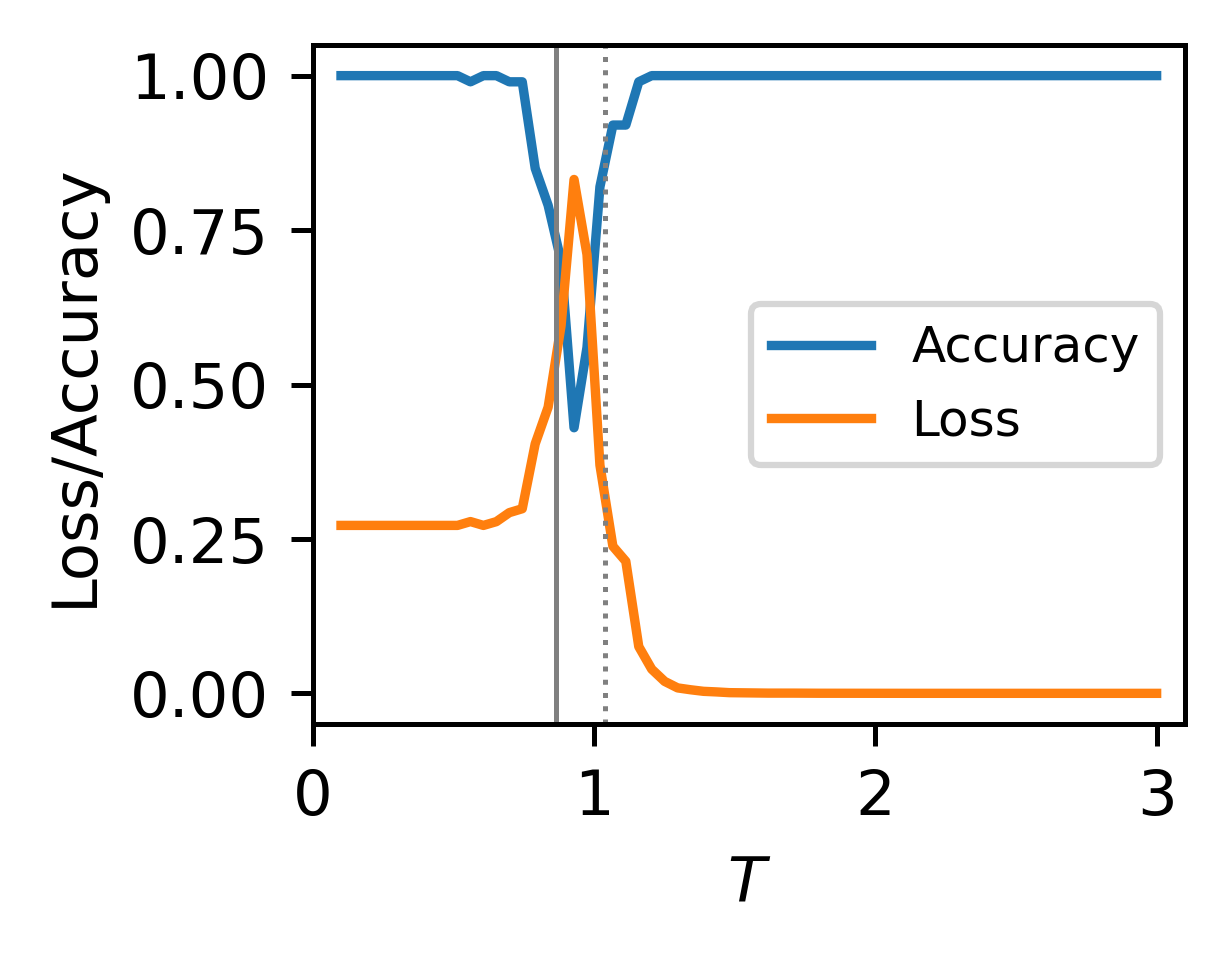

In [88]:
x= Ts_and_acc[0,:,0].flatten().cpu().numpy()
y=Ts_and_acc[0,:,1].flatten().cpu().numpy()
y2 =Ts_and_acc[0,:,2].flatten().cpu().numpy()
fig, ax  = plt.subplots(figsize=(2.5,2), dpi=450)
ax.plot(x, y, label="Accuracy")
ax.plot(x, y2, label="Loss")

ax.axvline(x=0.864, c="grey", lw=0.8)
ax.axvline(x=1.04, c="grey", lw=0.8, ls=":")
ax.set_ylabel("Loss/Accuracy")
ax.set_xlabel("$T$")
ax.legend(fontsize="8")
ax.set_xlim(0,3.1)
ax.set_ylim(-0.05,1.05)
print("")

## Calculate avg and mean and plot

Acc: [0.96796875 0.96703125 0.96703125 0.96859375 0.96796875] 
-> Avg: 0.9677187496842903 +/- 0.000605959885301832

Loss: [0.12695221 0.13267961 0.09877385 0.11478758 0.12364912] 
-> Avg: 0.11936847174546558 +/- 0.011816484327241729


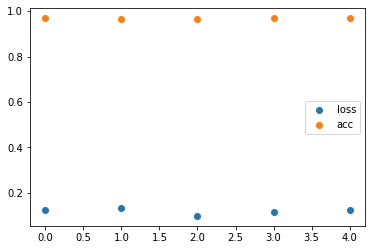

In [13]:
plt.scatter(range(results.shape[0]), results[:,0], label="loss")
plt.scatter(range(results.shape[0]), results[:,1], label="acc")
plt.legend()
means = np.mean(results, axis=0)
vars = np.var(results, axis=0)

print("Acc:", results[:,1], "\n-> Avg:", means[1], "+/-", np.sqrt(vars[1]))
print()
print("Loss:", results[:,0], "\n-> Avg:", means[0], "+/-", np.sqrt(vars[0]))

## Load fold scores

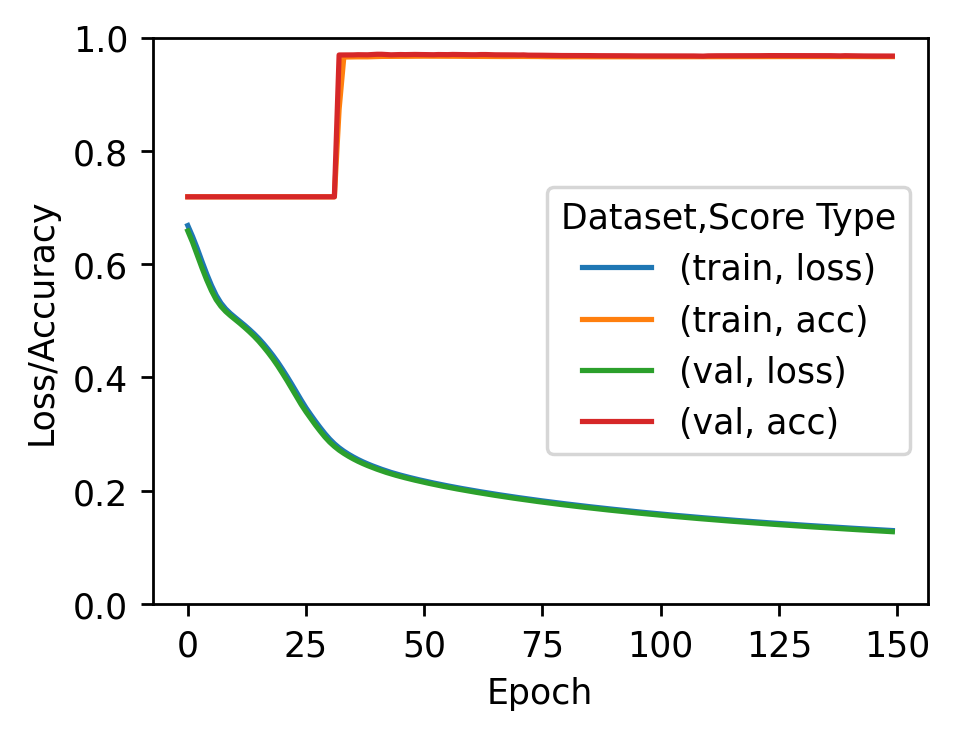

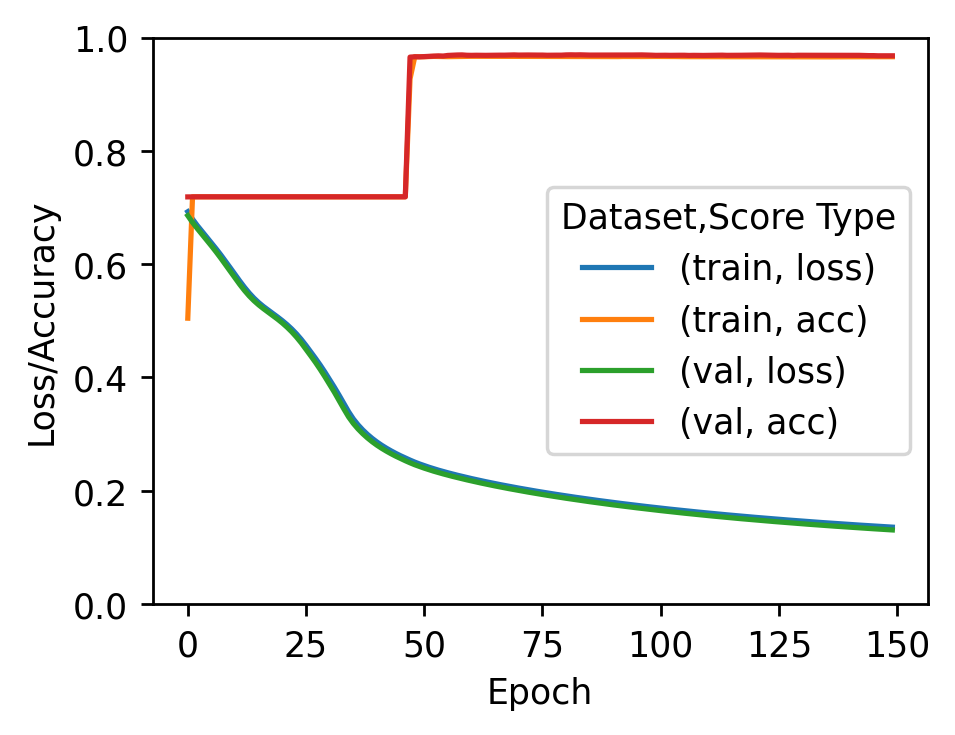

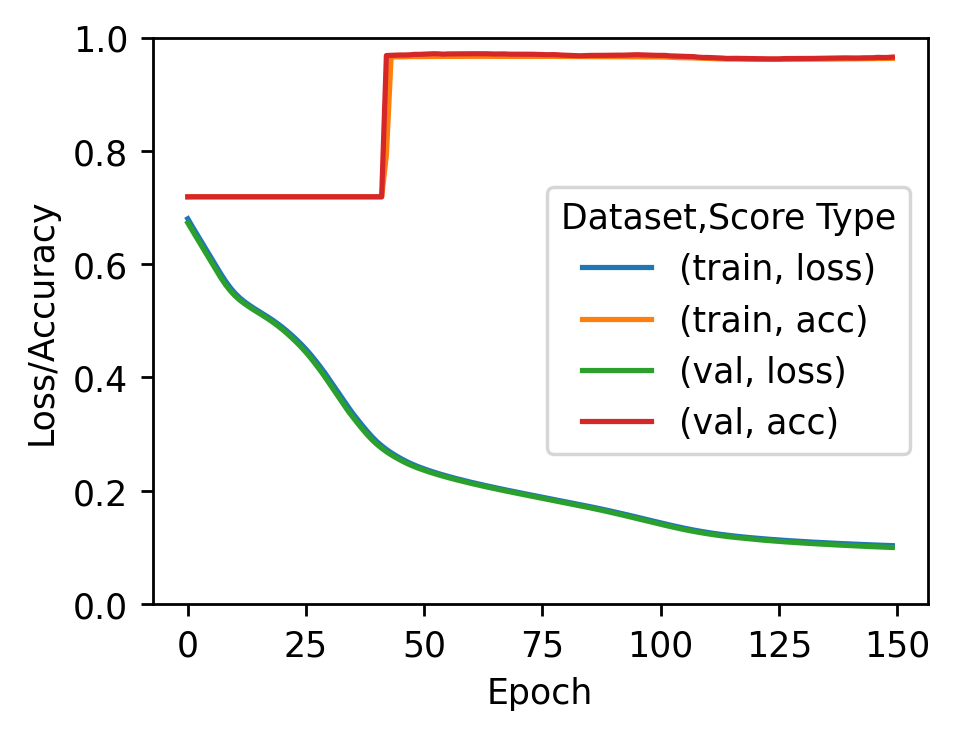

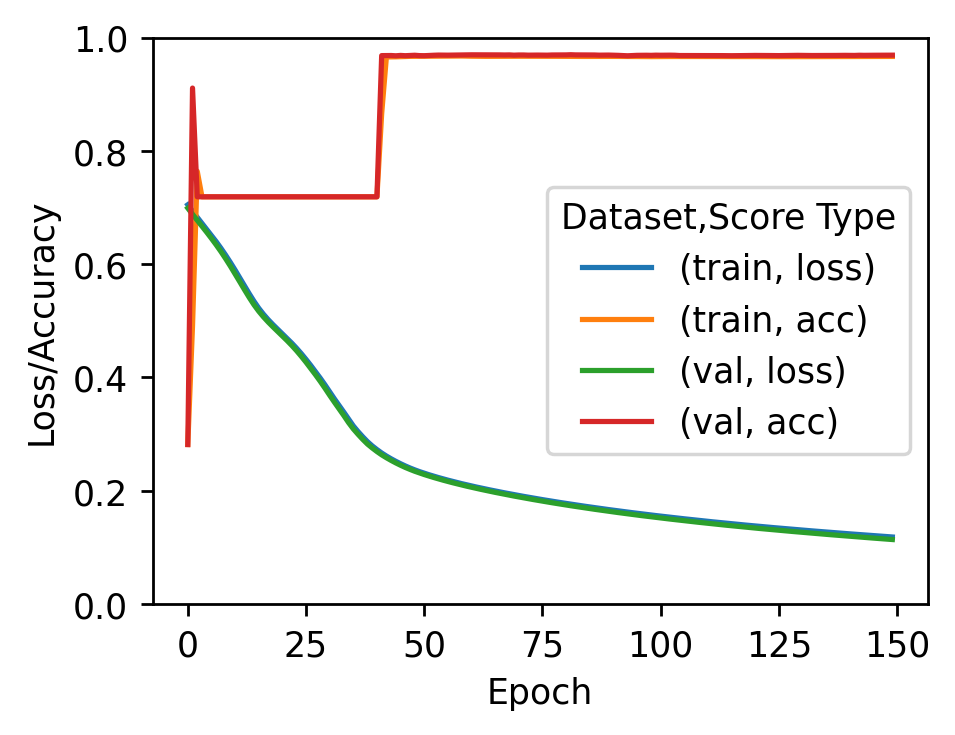

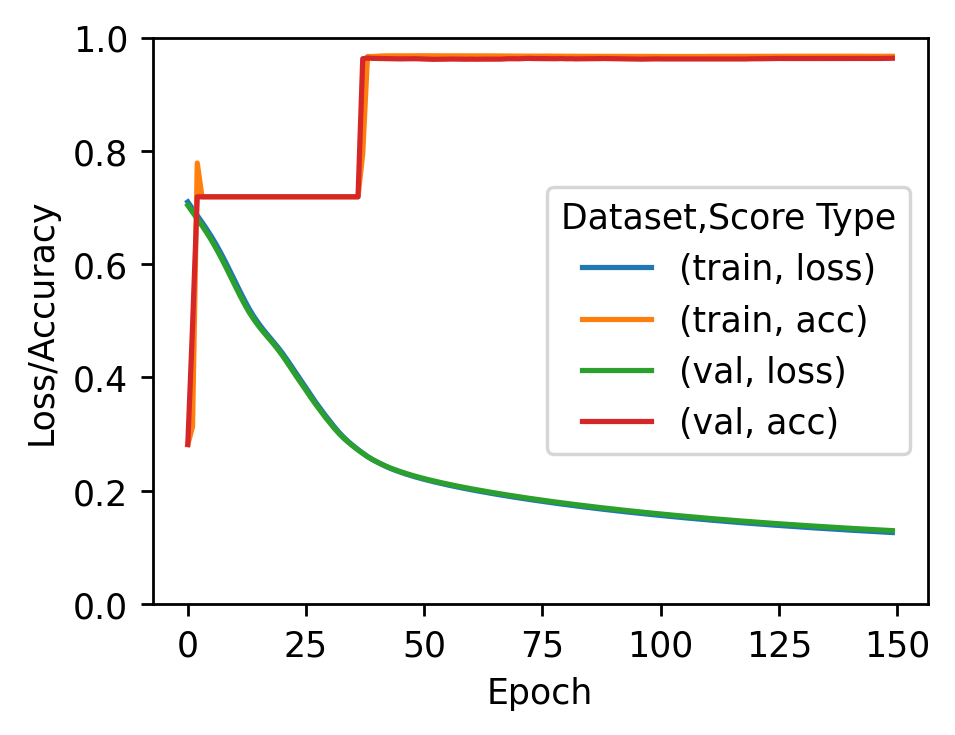

In [14]:
# temp locations
for i in range(folds):
  try:
    scores = get_scores(training_id, modelName, L, fold_id=i)
    fig, ax = plt.subplots(figsize=(4,3), dpi=250)
    ax.set_ylim(0,1)
    ax.set_ylabel("Loss/Accuracy")

    
    scores.plot(ax=ax)
  except:
    break

## Plot parameter distribution

Comparison can be made between same-layer parameters across different folds.

In [15]:
if False:
    axs = []
    for name, param in models[0].named_parameters():
        if param.requires_grad:
            fig, ax = plt.subplots()
            axs.append(ax)

    for model in models:
        i = 0
        for name, param in model.named_parameters():
            if param.requires_grad:
                # print(name, param.data.shape)
                data, edges = torch.histogram(param.data, bins=15, density=False)
                l_e = edges[:-1]
                width = 0.95*(l_e[1] - l_e[0])
                axs[i].bar(l_e, data, align='edge', width=width, label=i, alpha=0.5)
                i += 1

    for ax in axs:
      ax.legend()

# All-in-one

For mutiple models at different L.

Make sure all models have same `training_id`, can be fixed manually. 

In [ ]:
# --------------
# DATA & RESULTS
# --------------
print("Don't forget that performance has been saved.\nJust plot the right data.")
L_range = [8,16,32,64] # [8,16,24,32,40,48,56,64]
if True:
  modelNames = ["FFNN", "CNN", "CNN_vortices", "CustomNN_vortexInit", "CustomNN_randomInit"]
  
  folds = 10
  actual_folds = 5

  ids_FFNN  = [(1, "New"), (0, "CRAZY"),(1, "New"),(1, "New")]
  ids_CNN   = [(7908, "GG"),("0599", "TEMP"),(3, "ZERO"),(3, "ZERO")]
  ids_CNN_v = [(1, "New"), (536, "Newer2"), (1, "New"), (1, "New")]
  ids_Custom_v = [(16397, "REZERO"), (16397, "REZERO"), (3, "ZERO"), (3, "ZERO")]
  ids_Custom_r = [(55, "LongerRun"), (55, "LongerRun"), (55, "LongerRun"), (55, "LongerRun")]

  id_prefix_list = deepcopy(ids_FFNN)
  id_prefix_list.extend(ids_CNN)
  id_prefix_list.extend(ids_CNN_v)
  id_prefix_list.extend(ids_Custom_v)
  id_prefix_list.extend(ids_Custom_r)

  data = np.zeros((len(modelNames), len(L_range), actual_folds, 2))
  iteration = 0
  for modelName_i, L_i in product(range(len(modelNames)), range(len(L_range))):
    
    train_on_vortex = modelNames[modelName_i][-8:] == "vortices"
    print(f"Training on {'vortices' if train_on_vortex else 'spin angles'}.")
    training_id, prefix = id_prefix_list[iteration]
    data[modelName_i, L_i, :,:] = load_model_test_report_lossAcc(training_id, prefix, modelNames[modelName_i], L_range[L_i], folds, data_state_vortices=train_on_vortex)
    iteration += 1


  np.save("vs".join(modelNames) + ".npy", data)

Don't forget that performance has been saved.
Just plot the right data.
Training on spin angles.
Finding models at: data/test_results/NN_1_New_FFNN_L=8
Succesfully loaded in 5 models.
Succesfully loaded dataset (L=8) containing 6400 samples.
Succesfully tested FFNN model with an average acc of  82.73%
Training on spin angles.
Finding models at: data/test_results/NN_0_CRAZY_FFNN_L=16
Succesfully loaded in 5 models.
Succesfully loaded dataset (L=16) containing 6400 samples.
Succesfully tested FFNN model with an average acc of  85.27%
Training on spin angles.
Finding models at: data/test_results/NN_1_New_FFNN_L=32
Succesfully loaded in 5 models.
Succesfully loaded dataset (L=32) containing 6400 samples.
Succesfully tested FFNN model with an average acc of  87.79%
Training on spin angles.
Finding models at: data/test_results/NN_1_New_FFNN_L=64
Succesfully loaded in 5 models.
Succesfully loaded dataset (L=64) containing 6400 samples.
Succesfully tested FFNN model with an average acc of  72.

Text(0, 0.5, 'Loss')

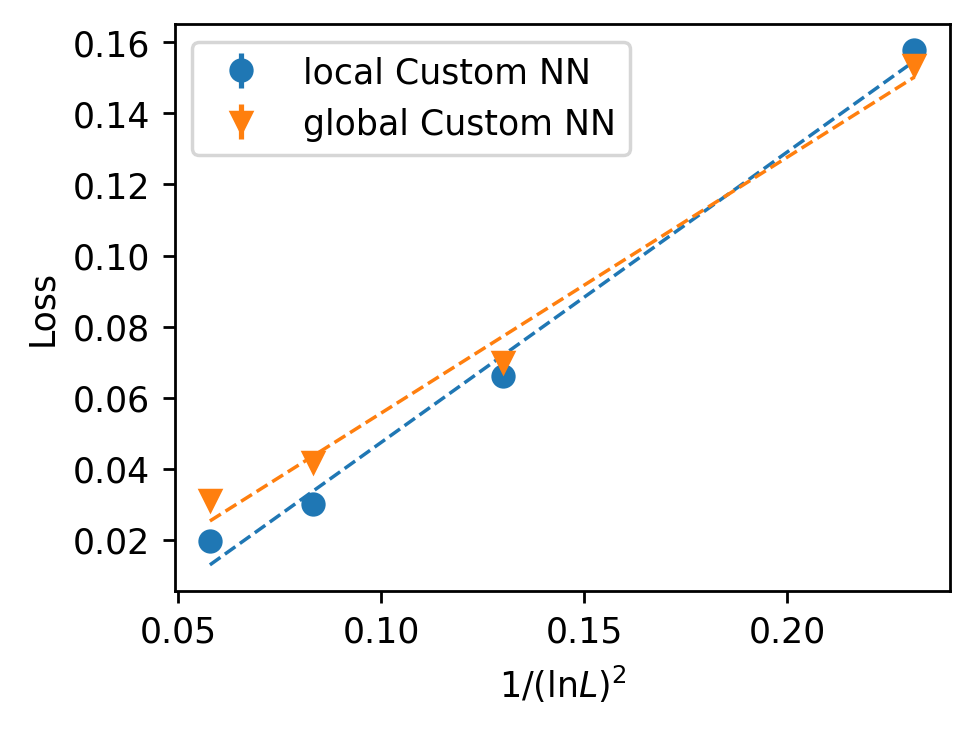

In [ ]:
# ----
# PLOT
# ----
from numpy import log as ln

data = np.load(os.path.join("data", "FFNNvsCNNvsCNN_vorticesvsCustomNN_vortexInitvsCustomNN_randomInit.npy"))
#print("data shape should be ~2,4,5,2. Is:", data.shape)#data.shape (5, 4, 5, 2) (modelname, L, fold, (loss,var))

# !!! SELECT MODELS HERE !!!
indices = [3,4]
# !!!

modelNames = np.array(["FFNN", "CNN", "CNN_vortices","CustomNN_vortexInit","CustomNN_randomInit"])
realNames = np.array(["FFNN", "CNN", "CNN vortices","local Custom NN","global Custom NN"])
modelNames = modelNames[indices]
means = np.mean(data, axis=2)
vars = np.var(data, axis=2)

fig, ax = plt.subplots(dpi=250, figsize=(4,3))
linestyles = ["solid", "dashed", "dotted"]
markers = ["o", "v", "^", "+", "x"]
if len(modelNames) > 3:
  linestyles = [(0, (1, 10)),(0, (1, 1)),(0, (1, 1)),
     (0, (5, 10)),(0, (5, 5)),
     (0, (5, 1)),(0, (3, 10, 1, 10)),
     (0, (3, 5, 1, 5)),(0, (3, 1, 1, 1)),
     (0, (3, 5, 1, 5, 1, 5)),(0, (3, 10, 1, 10, 1, 10)),
     (0, (3, 1, 1, 1, 1, 1))]
  markers = [(numsides, 1, 0) for numsides in range(3,11) ]

for modelName_i in range(len(modelNames)):
  xdata = ln(np.array(L_range))**(-2)
  xx = np.linspace(np.min(xdata), np.max(xdata))
  ydata = means[indices[modelName_i], :, 0]
  yvar = vars[indices[modelName_i], :, 0]
  
  if indices[modelName_i] == 0: # FFNN model
    fitf2 = np.poly1d(np.polyfit(xdata[:-1], ydata[:-1], 1))
    ax.plot(xx, fitf2(xx), "--", linewidth=.5, c=f"C{modelName_i}", alpha=.5)
  fitf = np.poly1d(np.polyfit(xdata, ydata, 1))
  ax.errorbar(xdata, ydata, yerr=yvar , label="fixed Custom NN" if (indices[0] == 2 and indices[1] == 3 and modelName_i == 0) else realNames[indices[modelName_i]],
          fmt=markers[modelName_i], c=f"C{modelName_i}")
  ax.plot(xx, fitf(xx), "--", linewidth=1, c=f"C{modelName_i}")

ax.legend()
xlabel = "$1/(\ln{L})^2$" if True else "$L$"
ax.set_xlabel(xlabel)
ax.set_ylabel("Loss")

# All-in-one SIZES

In [ ]:
# --------------
# DATA & RESULTS
# --------------

train_models_different_data_set_sizes = False
if train_models_different_data_set_sizes:
  training_id = 999
  prefix = "SIZE"
  modelNames = ["FFNN_vortices"] # ["FFNN", "CNN", "CustomNN"] 
  L_range = [8] # [8,16,24,32,40,48,56,64]
  folds = 10
  actual_folds = 5
  train_on_vortex = False
  size_range = [1,5,10,50,100,150,200,400,800]

  data = np.zeros((len(modelNames), len(L_range), len(size_range), actual_folds, 2))

  for modelName_i, L_i, size_i in product(range(len(modelNames)), range(len(L_range)), range(len(size_range))):
    prefix += f"={size_range[size_i]}"
    data[modelName_i, L_i, size_i, :,:] = load_model_test_report_lossAcc(training_id, prefix, modelNames[modelName_i], L_range[L_i], folds, data_state_vortices=train_on_vortex, pathToThesis=ptt)


In [ ]:
# ----
# PLOT
# ----
if train_models_different_data_set_sizes:
  #data.shape (2, 4, 5, 2)
  means = np.mean(data, axis=3)
  vars = np.var(data, axis=3)


  # print(data.shape) # (1, 1, 9, 5, 2) = models, L, folds, 2
  # print(means.shape) # (1, 1, 9, 2)  = models, L, 2


  fig, ax = plt.subplots(dpi=150, figsize=(4,3))
  linestyles = ["solid", "dashed", "dotted"]
  markers = ["o", "v", "^"]
  for modelName_i in range(len(modelNames)):
    ax.plot([a*64 // 1000 for a in size_range[4:]], means[modelName_i, 0, :, 0][4:], label=modelNames[modelName_i],
            marker=markers[modelName_i], ls=linestyles[modelName_i])

  ax.legend()
  ax.set_xlabel("Size of data set $[10^3]$")
  ax.set_ylabel("Loss")

# Train model on fake data
To test if model can learn to predict only one class.

In [ ]:
# ----
# DATA
# ----
train_model_on_fake_data = False
if train_model_on_fake_data:
    N = 6400 # 6400
    L = 32
    T_low = True

    degrees_separation = 25

    train_data = gen_fake_data(N, L, T_low, degrees_seperation=degrees_separation, silence=False)
    Ts = np.repeat(np.array([0.15 if T_low else 2.5]), N) 

    train_data = CustomDataset.usingData(L, train_data, Ts, normalize=True)
    train_data.labels = train_data.labels.reshape(train_data.labels.shape[0],1)

    # --------
    # TRAINING
    # --------
    # train on fake data
    bs = 25
    epochs = 50
    learning_rate = 1e-1

    criterion = nn.BCELoss(reduction='sum')

    train_sampler = SequentialSampler(train_data)
    train_loader = DataLoader(
        train_data, batch_size=bs, sampler=train_sampler)

    model = CNN(L, normalized_data_bool=False)

    scores = np.zeros((epochs, 2))

    num_samples_fold = len(train_data)
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    for epoch_id, epoch in tqdm(enumerate(range(epochs)), total=epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in train_loader:
            num_samples_batch = len(data)
            data = data.to(device)
            label = label.to(device).float().view((num_samples_batch, 1))

            output = model(data)

            batch_loss = criterion(output, label)

            optimizer.zero_grad()  # reset accumulation of gradients
            batch_loss.backward()  # grad calc for all pms who req grad
            optimizer.step()  # updates pms

            # threshold value of 0.5 to determine class.
            batch_acc = ((output > 0.5).float() == label).float().sum()
            epoch_accuracy += batch_acc.item() / num_samples_fold
            epoch_loss += batch_loss.item() / num_samples_fold
        scores[epoch_id, :] = epoch_loss, epoch_accuracy


In [ ]:
# ----
# PLOT
# ----
if train_model_on_fake_data:
    plt.plot(range(epochs), scores[:,0], label="loss")
    plt.plot(range(epochs), scores[:,1], label="acc")
    plt.legend()

# IMD visualization
Compare before training and after training distribution.

Compare this for vortexInit and randomInit. 

In [ ]:
L = 64
L_id = 0
L_range = [16]
training_id = 3
prefix = "ZERO"
modelName = "CustomNN_randomInit"
folds = 10


modelName = prefix + "_" + modelName
batch_size=2500
data_set_normalization = True
device = "cpu"
custom_model_save_intermittent = True
vortexInit = False
usedDataSet_trainSet =  False

Succesfully loaded data set containing 6400 samples.
model performance (loss/acc): 0.701198955376943 and 0.2908952335516612


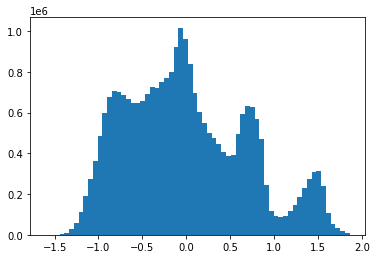

In [ ]:
# BEFORE TRAINING
# ---------------
model = Custom(L, vortexInit=vortexInit ,save_intermittent=custom_model_save_intermittent, normalized_data_bool=data_set_normalization, device=device)
# Custom(L, vortexInit=True ,save_intermittent=custom_model_save_intermittent, normalized_data_bool=data_set_normalization, device=device)

dataset = load_data_from_pickle(L, Tc0, pathToThesis=ptt, trainSet=usedDataSet_trainSet, train_on_vortex=False, device="cpu")
print(f"Succesfully loaded data set containing {len(dataset)} samples.")

# get initial distribution before training
imdfresh = np.empty((len(dataset), L, L))
model.save_intermittent = True

#for model_id, model in enumerate(models):
model_loss, model_acc = 0,0

sample_id = 0

data_sampler = SequentialSampler(dataset)
data_loader = DataLoader(dataset, batch_size=batch_size, sampler=data_sampler)
num_batches = len(data_loader)

# eval mode because more efficient
model.eval() # eval mode, not model.train() for train mode
with torch.no_grad(): # no grad calculations
  for data, label in data_loader:
    num_samples_batch = len(data)
    
    output = model(data)      
    batch_loss = criterion(output, label)
    
    # threshold value of 0.5 to determine class.
    batch_acc = ((output > 0.5).float() == label).float().mean().item()
    model_acc += batch_acc / num_batches
    model_loss += batch_loss.item() / num_batches

    if model.name == "CustomNN" and model.save_intermittent:
      imdfresh[sample_id:sample_id+num_samples_batch,:,:] = model.intermediate_data
      sample_id += num_samples_batch

imdfresh = torch.from_numpy(imdfresh).float()
print("model performance (loss/acc):", model_loss, "and", model_acc)

plot_torch_distr(imdfresh)

Finding models at: data/test_results/NN_3_ZERO_CustomNN_randomInit_L=64
Succesfully loaded in 5 models.
model performance (loss/acc): 0.038155404229958854 and 0.9865333239237466
model performance (loss/acc): 0.062331622163454746 and 0.9845333298047383
model performance (loss/acc): 0.0400955340782844 and 0.9858666658401489
model performance (loss/acc): 0.057147352830586286 and 0.9831999937693277
model performance (loss/acc): 0.02257956067721049 and 0.9917333324750264
True


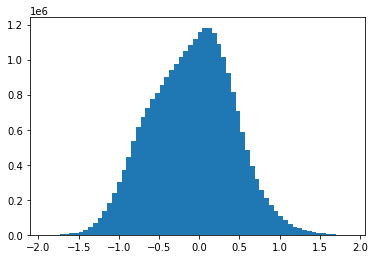

In [ ]:
# AFTER TRAINING
# --------------
models = get_models_test_results(training_id, modelName, folds, L)

imd = np.empty((len(models), len(L_range), len(dataset), L, L))
for model_id, model in enumerate(models):
  model.save_intermittent = True

  #for model_id, model in enumerate(models):
  model_loss, model_acc = 0,0

  sample_id = 0

  data_sampler = SequentialSampler(dataset)
  data_loader = DataLoader(dataset, batch_size=batch_size, sampler=data_sampler)
  num_batches = len(data_loader)

  # eval mode because more efficient
  model.eval() # eval mode, not model.train() for train mode
  with torch.no_grad(): # no grad calculations
    for data, label in data_loader:
      num_samples_batch = len(data)
      
      output = model(data)      
      batch_loss = criterion(output, label)
      
      # threshold value of 0.5 to determine class.
      batch_acc = ((output > 0.5).float() == label).float().mean().item()
      model_acc += batch_acc / num_batches
      model_loss += batch_loss.item() / num_batches

      if model.name == "CustomNN" and model.save_intermittent:
        imd[model_id, L_id, sample_id:sample_id+num_samples_batch,:,:] = model.intermediate_data
        sample_id += num_samples_batch
      
  print("model performance (loss/acc):", model_loss, "and", model_acc)
print(model.save_intermittent)
model(dataset.configs) # torch.zeros(1,1,64,64)
plot_torch_distr(torch.from_numpy(model.intermediate_data))

ZERO_CustomNN_randomInit 64
ZERO_CustomNN_randomInit 64
ZERO_CustomNN_randomInit 64
ZERO_CustomNN_randomInit 64
ZERO_CustomNN_randomInit 64


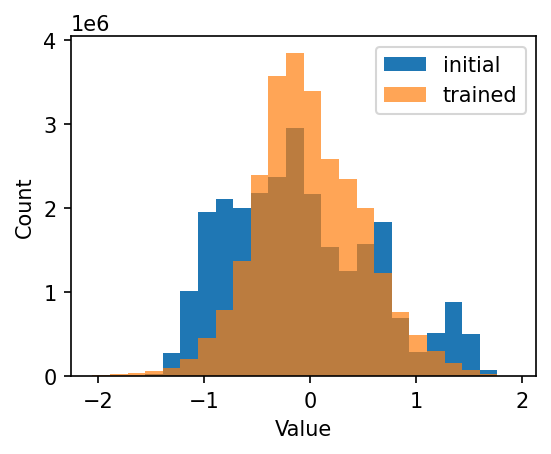

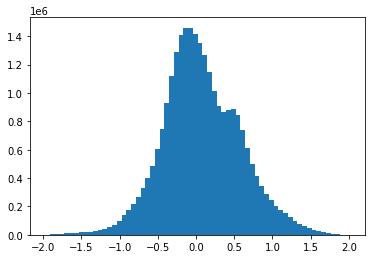

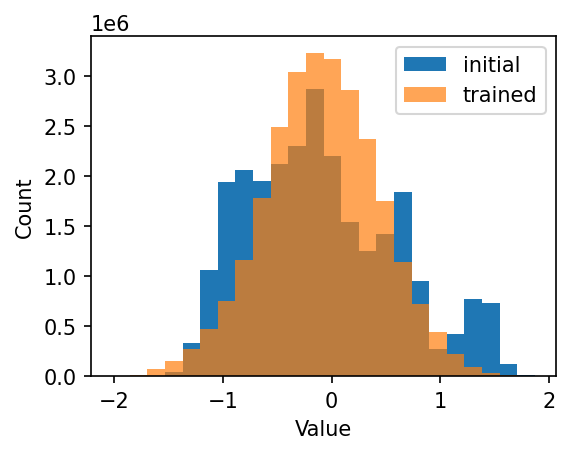

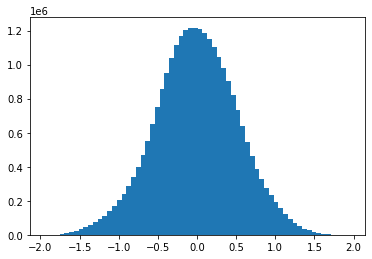

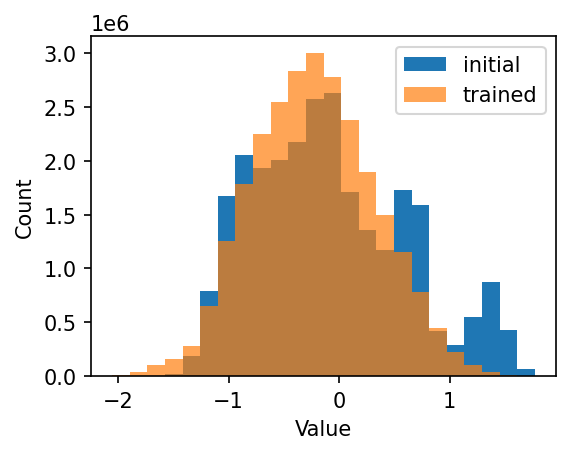

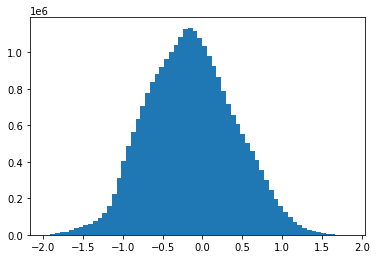

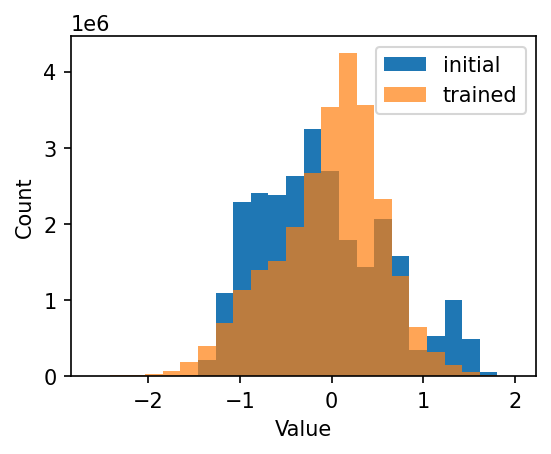

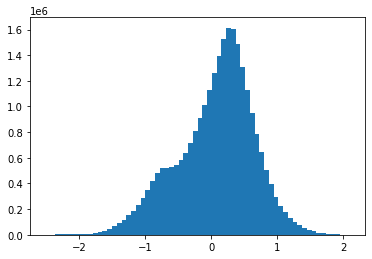

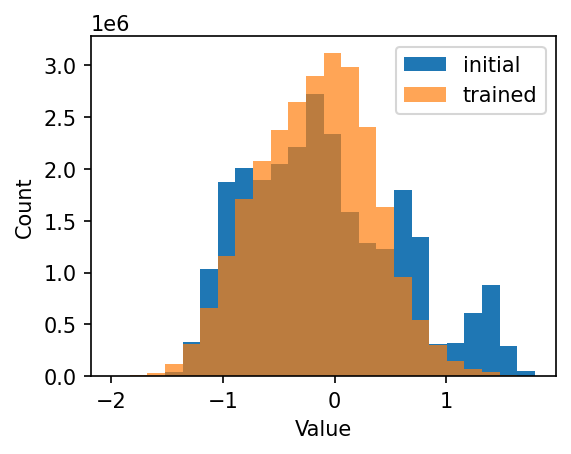

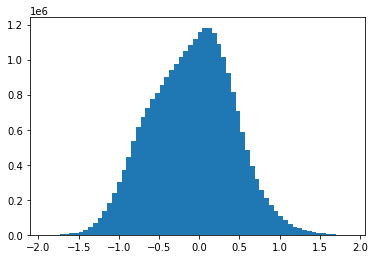

In [ ]:
printParameters = False
for model_id, model in enumerate(models[::-1]):
  print(modelName, L)
  minval =  min(torch.min(d.configs).item(), np.min(imd[model_id, L_id]).item())
  maxval =  max(torch.max(d.configs).item(), np.max(imd[model_id, L_id]).item())
  bins = np.linspace(minval-1e-3, maxval+1e-3, num=25)
  widthPerBin = (maxval - minval) / (len(bins)-1)

  fig, ax = plt.subplots(dpi=150, figsize=(4*1,3*1))
  
  # initialized model
  histdata, edges = torch.histogram(imdfresh, torch.from_numpy(bins).float())
  ax.bar(bins[:-1], histdata, align='center', width =widthPerBin, label="initial", alpha=1)

  # trained model
  histdata, edges = torch.histogram(torch.from_numpy(imd[model_id, L_id]).float(), torch.from_numpy(bins).float())
  plot_torch_distr(torch.from_numpy(imd[model_id, L_id]))
  ax.bar(bins[:-1], histdata, align='center', width = widthPerBin, label="trained", alpha=0.7)

  ax.legend()
  ax.set_xlabel("Value")
  ax.set_ylabel("Count")

  
  for name, param in model.named_parameters():
    if param.requires_grad:
      if name[:len("convVortex")] == "convVortex":
        if printParameters:
          print(name, param.data)

## All IMDs visualized at once
For both models. Savefigged.

In [ ]:
def get_imd(model, dataset, batch_size, criterion=criterion, plotDistr=False):
  """
  Model is evaluated on dataset and imd is returned.
  Only works for CustomNN model.
  Reports on loss/acc as well.
  """
  # get initial distribution before training
  imdfresh = np.empty((len(dataset), model.L, model.L))

  # imd must be saved
  model.save_intermittent = True

  #for model_id, model in enumerate(models):
  model_loss, model_acc = 0,0

  sample_id = 0

  data_sampler = SequentialSampler(dataset)
  data_loader = DataLoader(dataset, batch_size=batch_size, sampler=data_sampler)
  num_batches = len(data_loader)

  # eval mode because more efficient
  model.eval() # eval mode, not model.train() for train mode
  with torch.no_grad(): # no grad calculations
    for data, label in data_loader:
      num_samples_batch = len(data)
      print(data.shape)
      output = model(data)      
      batch_loss = criterion(output, label)
      
      # threshold value of 0.5 to determine class.
      batch_acc = ((output > 0.5).float() == label).float().mean().item()
      model_acc += batch_acc / num_batches
      model_loss += batch_loss.item() / num_batches

      # save data per batch
      if model.name == "CustomNN" and model.save_intermittent:
        imdfresh[sample_id:sample_id+num_samples_batch,:,:] = model.intermediate_data
        sample_id += num_samples_batch

  # right data type
  imdfresh = torch.from_numpy(imdfresh).float()

  print("model performance (loss/acc):", model_loss, "and", model_acc)

  if plotDistr:
    plot_torch_distr(imdfresh)
  
  return imdfresh

In [ ]:
# load model
folds = 10
L = 16
normalized_data = True
usedDataSet_trainSet =  False
batch_size = 2500
data_set_normalization = True
device = "cpu"

# load data
dataset = load_data_from_pickle(L, Tc0, pathToThesis=ptt, trainSet=usedDataSet_trainSet, train_on_vortex=False, device="cpu")
#vortices = dataset.get_vortex_from_spin()
print(f"Succesfully loaded data set containing {len(dataset)} samples.")

# for both models
for vortexInit in [True, False]:
  modelName = "CustomNN_vortexInit" if vortexInit else "CustomNN_randomInit"
  modelName_og = deepcopy(modelName)
  print("processing:", modelName)
  
  # initialized model
  model_new = Custom(L, vortexInit=vortexInit, normalized_data_bool=data_set_normalization, device=device)
  imd_new = get_imd(model_new, dataset, batch_size)
  print("init model data acquired.")

  # trained model
  id_prefix_Lsixteen_dict = {
    "FFNN": (0, "CRAZY"),
    "CNN": ("0599", "TEMP"),
    "CNN_vortices":(536, "Newer2"),
    "CustomNN_vortexInit":(16397, "REZERO"),
    "CustomNN_randomInit":(55, "LongerRun")}
  if L == 16:
    print("Modelname Parameters Overwritten, because L==16")
    training_id, prefix = id_prefix_Lsixteen_dict[modelName]
  modelName = prefix + "_" + modelName
  models = get_models_test_results(training_id, modelName, folds, L)

  for model_id, model in enumerate(models):
    # get data to plot
    imd = get_imd(model, dataset, batch_size)
      
    minval =  min(torch.min(imd_new).item(), np.min(imd).item())
    maxval =  max(torch.max(imd_new).item(), np.max(imd).item())
    bins = np.linspace(minval-1e-3, maxval+1e-3, num=25)
    widthPerBin = (maxval - minval) / (len(bins)-1)

    fig, ax = plt.subplots(figsize=(4,3), dpi=250)

    # initialized model
    histdata, edges = torch.histogram(imdfresh, torch.from_numpy(bins).float())
    ax.bar(bins[:-1], histdata, align='center', width =widthPerBin, label="initial", alpha=1)

    # trained model
    histdata, edges = torch.histogram(torch.from_numpy(imd[model_id, L_id]).float(), torch.from_numpy(bins).float())
    plot_torch_distr(torch.from_numpy(imd[model_id, L_id]))
    ax.bar(bins[:-1], histdata, align='center', width = widthPerBin, label="trained", alpha=0.7)

    ax.legend()
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")
    
    fig.savefig(os.path.join("data", "imd", f"{modelName_og}_imd_fold={i}.png"),
              bbox_inches='tight')
    
    plt.close("all")
    break
  break

Succesfully loaded data set containing 6400 samples.
processing: CustomNN_vortexInit
torch.Size([2500, 16, 16])
torch.Size([2500, 16, 16])
torch.Size([2500, 16, 16])
unsq torch.Size([2500, 1, 16, 16])
cv1 torch.Size([2500, 8, 14, 14])
cv2 torch.Size([2500, 16, 12, 12])
mxpool torch.Size([2500, 16, 6, 6])
reshape torch.Size([2500, 576])
relu torch.Size([2500, 32])
torch.Size([2500, 16, 16])
torch.Size([2500, 16, 16])
torch.Size([2500, 16, 16])
unsq torch.Size([2500, 1, 16, 16])
cv1 torch.Size([2500, 8, 14, 14])
cv2 torch.Size([2500, 16, 12, 12])
mxpool torch.Size([2500, 16, 6, 6])
reshape torch.Size([2500, 576])
relu torch.Size([2500, 32])
torch.Size([1400, 16, 16])
torch.Size([1400, 16, 16])
torch.Size([1400, 16, 16])
unsq torch.Size([1400, 1, 16, 16])
cv1 torch.Size([1400, 8, 14, 14])
cv2 torch.Size([1400, 16, 12, 12])
mxpool torch.Size([1400, 16, 6, 6])
reshape torch.Size([1400, 576])
relu torch.Size([1400, 32])
model performance (loss/acc): 0.7014491160710653 and 0.2531619146466255


NameError: ignored